<a href="https://colab.research.google.com/github/Lalchand-b/another_repo_example/blob/main/food_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.18.0
/device:GPU:0


In [ ]:
#import tensorflow as tf
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 1


In [ ]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
# Download data and extract it to folder

get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
%cd /content/food-101

/content/food-101


In [ ]:
# Check the extracted dataset folder
!ls /content/food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('/content/food-101/images')

['pulled_pork_sandwich',
 'frozen_yogurt',
 'fried_rice',
 'ravioli',
 'pizza',
 'grilled_salmon',
 'foie_gras',
 'miso_soup',
 'pad_thai',
 'pho',
 'donuts',
 'macarons',
 'ceviche',
 'risotto',
 'churros',
 'gyoza',
 'baklava',
 'beef_tartare',
 'chicken_quesadilla',
 'seaweed_salad',
 'samosa',
 'dumplings',
 'lobster_roll_sandwich',
 'apple_pie',
 'cheese_plate',
 'escargots',
 'clam_chowder',
 'hot_and_sour_soup',
 'huevos_rancheros',
 'caesar_salad',
 'paella',
 'baby_back_ribs',
 'edamame',
 'oysters',
 'nachos',
 'chicken_curry',
 'takoyaki',
 'tuna_tartare',
 'french_onion_soup',
 'beignets',
 'breakfast_burrito',
 'crab_cakes',
 'onion_rings',
 'bruschetta',
 'croque_madame',
 'beef_carpaccio',
 'beet_salad',
 'strawberry_shortcake',
 'sashimi',
 'tiramisu',
 'chocolate_cake',
 'lasagna',
 'spaghetti_bolognese',
 'caprese_salad',
 'hot_dog',
 'sushi',
 'filet_mignon',
 'garlic_bread',
 'chicken_wings',
 'bread_pudding',
 'ice_cream',
 'ramen',
 'cup_cakes',
 'deviled_eggs',
 

In [ ]:
os.listdir('/content/food-101/meta')

['classes.txt',
 'test.txt',
 'labels.txt',
 'train.txt',
 'train.json',
 'test.json']

In [ ]:
!head /content/food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!head /content/food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


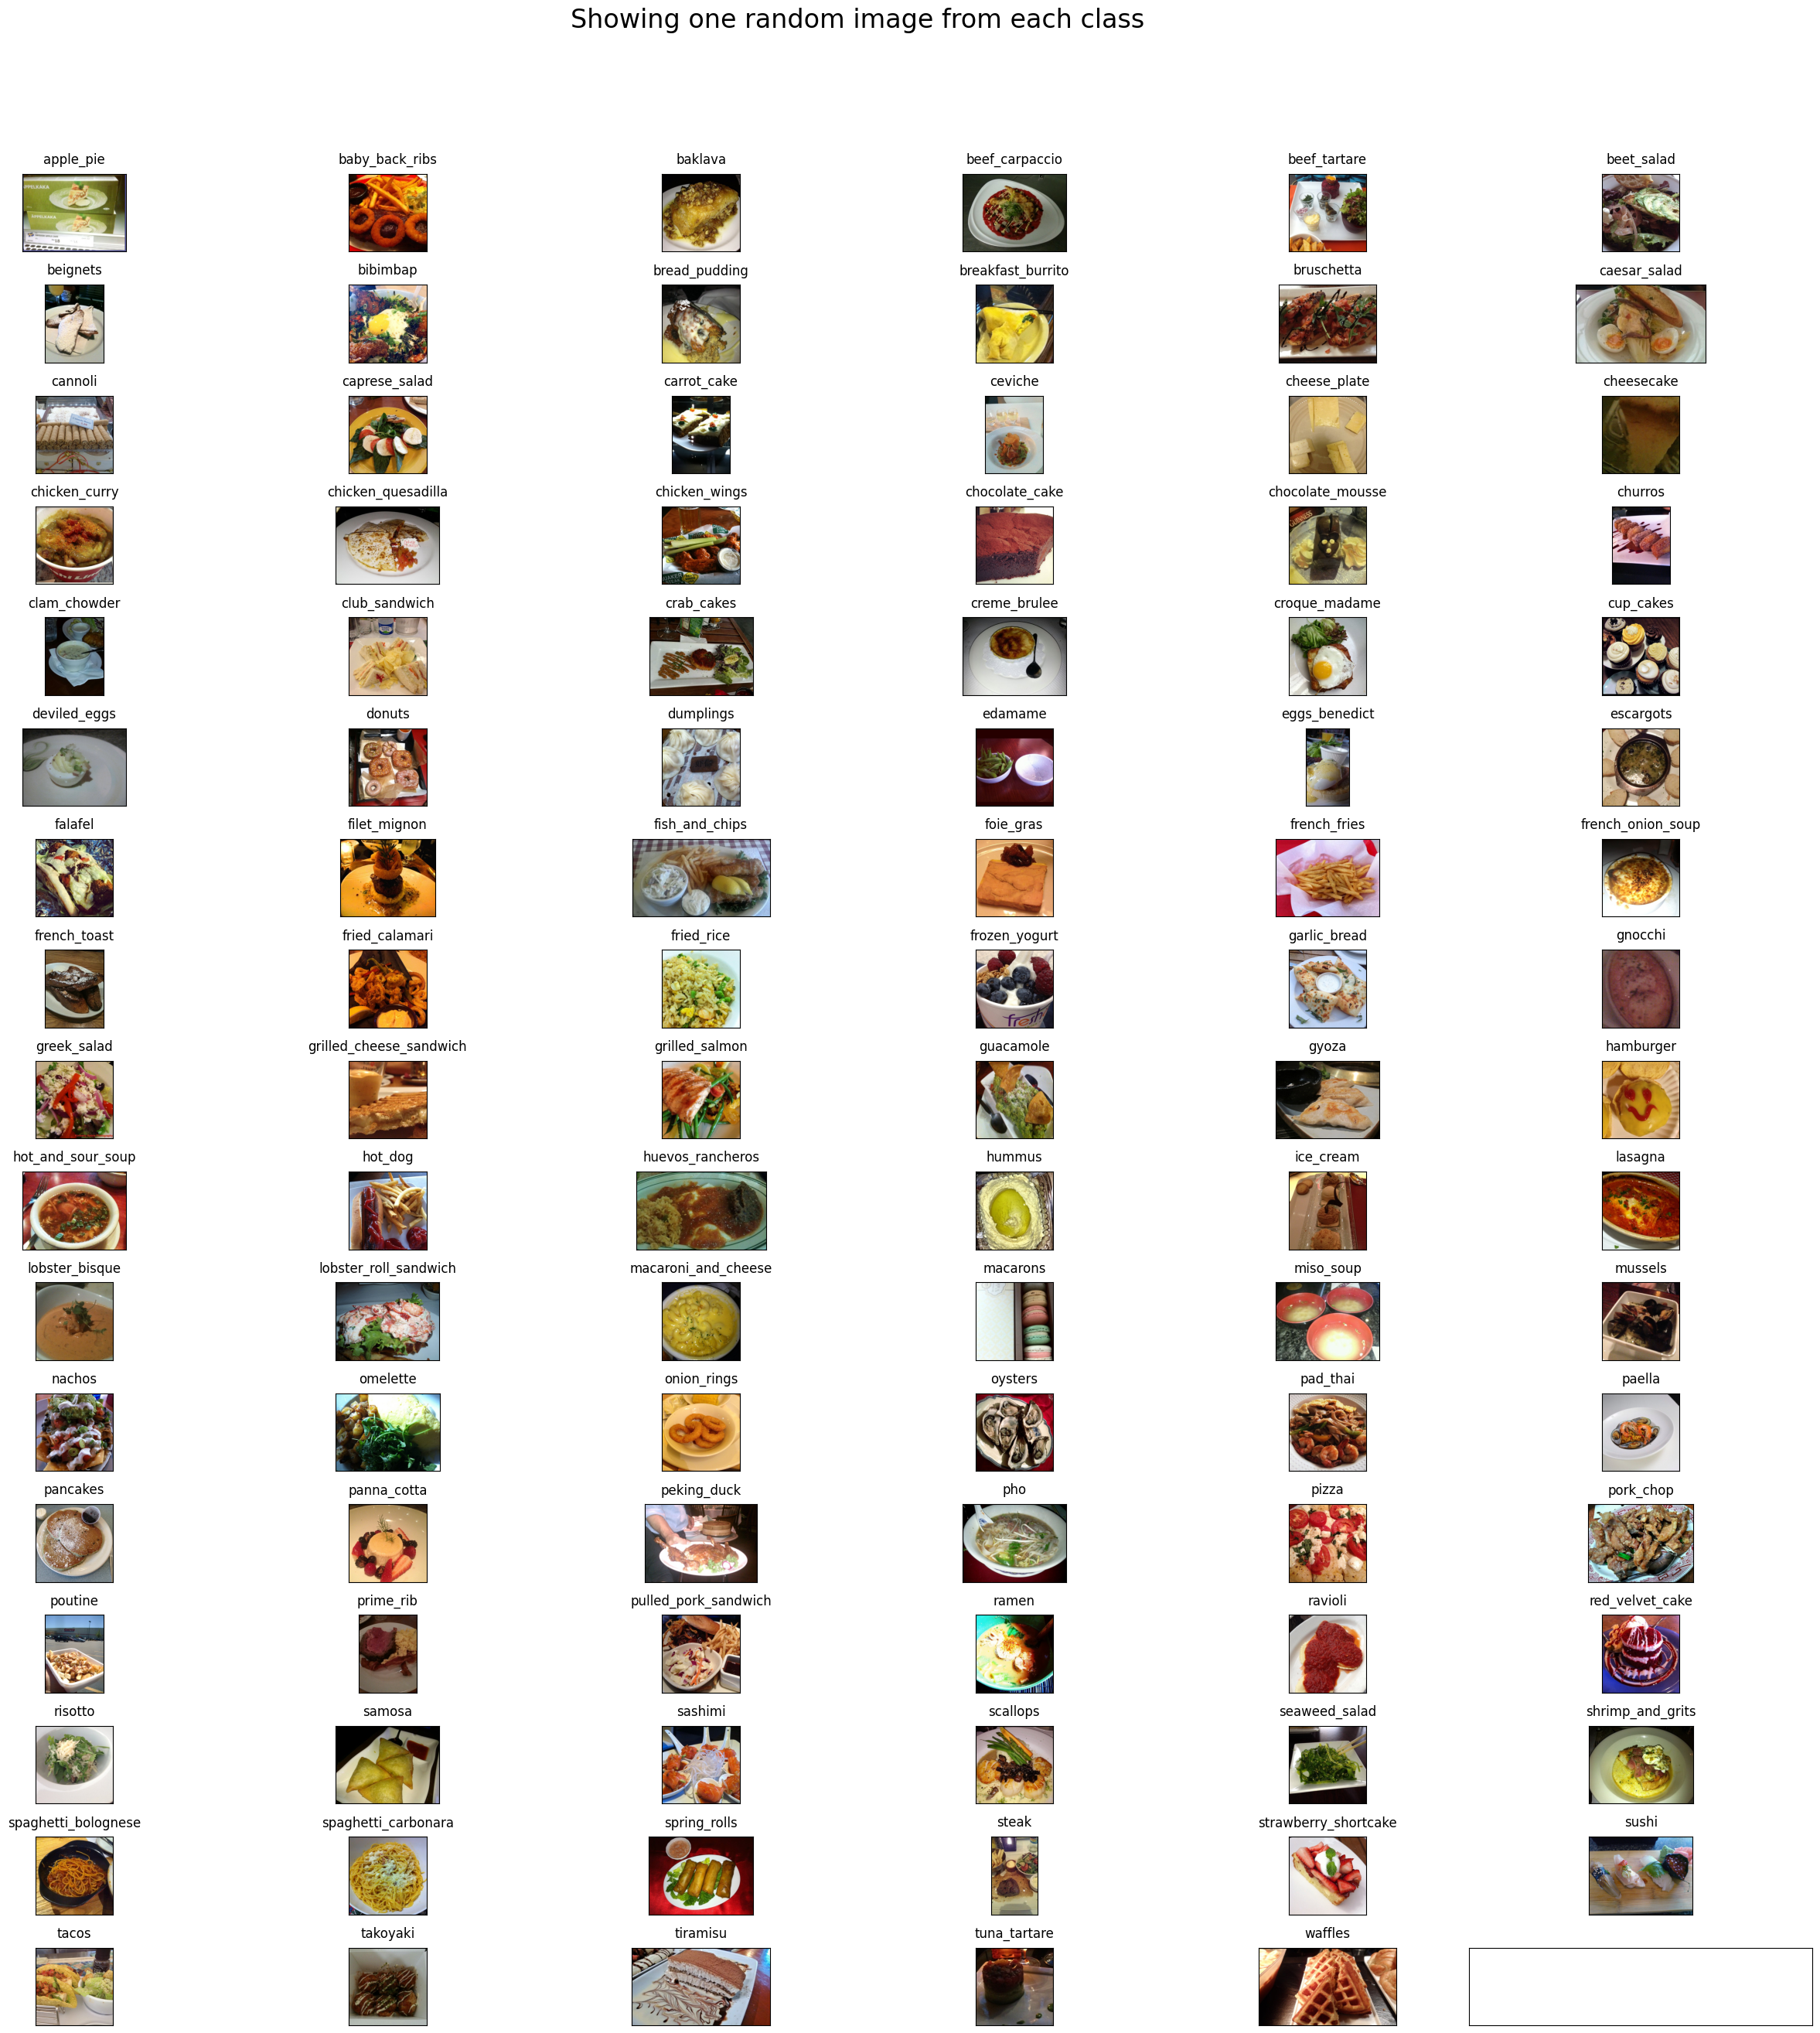

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
os.chdir('/')

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [ ]:
import os

# Picking 3 food items
food_list = ['apple_pie', 'pizza', 'omelette']

# Source paths for Food-101 dataset in Colab
src_train = '/content/food-101/images'
src_test = '/content/food-101/images'

# Destination paths for new subsets
dest_train = '/content/train_mini'
dest_test = '/content/test_mini'

# Create destination directories if they don't exist
for folder in [dest_train, dest_test]:
    os.makedirs(folder, exist_ok=True)


In [ ]:
# # picking 3 food items and generating separate data folders for the same
# food_list = ['apple_pie','pizza','omelette']
# src_train = 'train'
# dest_train = '/kaggle/working/train_mini'
# src_test = 'test'
# dest_test = '/kaggle/working/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find /content/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
3000


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find /content/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
3000


In [ ]:
# hit and trial code
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Clear any previous models in memory
tf.keras.backend.clear_session()

# Number of classes
n_classes = 3
img_width, img_height = 224, 224

# Paths updated for Google Colab
train_data_dir = '/content/train_mini'
validation_data_dir = '/content/test_mini'

batch_size = 16

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Sample sizes (adjust if needed)
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)



print(f"Train steps per epoch: {steps_per_epoch}")
print(f"Validation steps per epoch: {validation_steps}")

# Load pre-trained ResNet50 model without top layers
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Add custom layers for classification
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Create model
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ FIX: Update file extensions from `.hdf5` to `.keras`
checkpointer = ModelCheckpoint(filepath='/content/best_model_3class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/history_3class.log')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer])

# ✅ FIX: Save the final model with `.keras` extension
model.save('/content/model_trained_3class.keras')

print("✅ Model training complete and saved in `.keras` format!")


Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Train steps per epoch: 188
Validation steps per epoch: 188
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4568 - loss: 1.0988
Epoch 1: val_loss improved from inf to 2.05164, saving model to /content/best_model_3class.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 450ms/step - accuracy: 0.4573 - loss: 1.0980 - val_accuracy: 0.3330 - val_loss: 2.0516
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7224 - loss: 0.7048
Epoch 2: val_loss did not improve from 2.05164
188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 302ms/step - accuracy: 0.7225 - loss: 0.7046 - val_accuracy: 0.3337 - val_loss: 2.2378
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8118 - loss: 0.5487
Epoch 3: val_loss improved from 2.05164 to 1.64346, saving model to /content/best_model_3class.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 316ms/step - accuracy: 0.8118 - loss: 0.5486 - val_accuracy: 0.3867 - val_loss: 1.6435
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8293 - loss: 0.4856
Epoch 4: val_loss improved from 1.64346 to

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

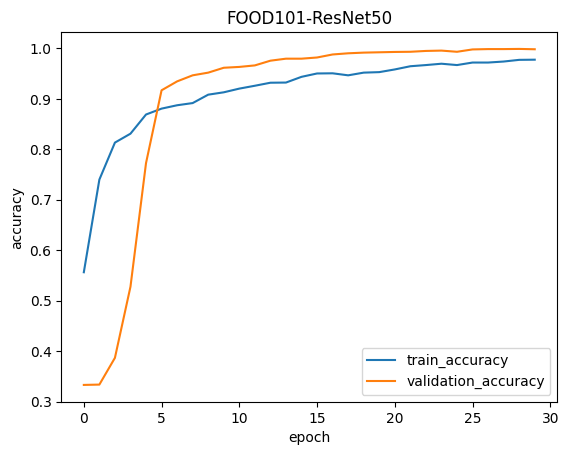

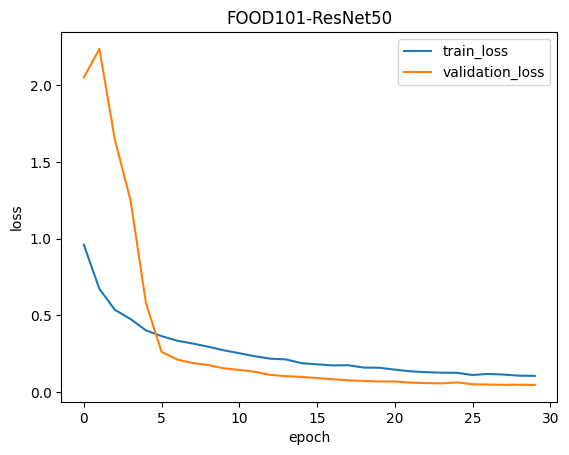

In [ ]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

In [ ]:
#random _test
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/content/best_model_3class.keras',compile = False)

CPU times: user 1.99 s, sys: 182 ms, total: 2.17 s
Wall time: 2.17 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
!wget -O pizza.jpg https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg?w=2000
!wget -O omelette.jpg https://cdn.pixabay.com/photo/2015/05/20/16/11/kitchen-775746_640.jpg

--2025-04-06 07:08:04--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 172.67.139.59, 104.21.79.5, 2606:4700:3036::6815:4f05, ...
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg [following]
--2025-04-06 07:08:04--  https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-06 07:08:06 ERROR 404: Not Found.

--2025-04-06 07:08:06--  https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connec

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


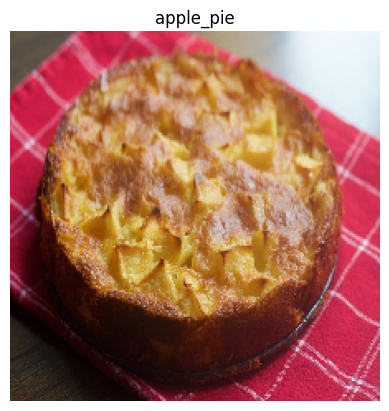

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


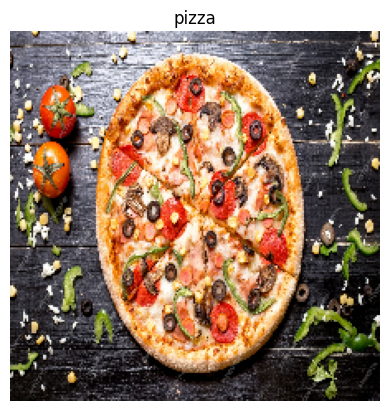

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


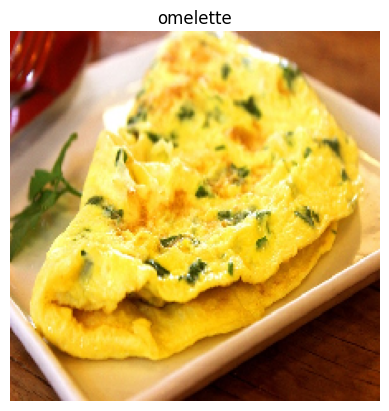

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
predict_class(model_best, images, True)

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in train folder")
!find /content/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
11000


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in test folder")
!find /content/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
11000


In [ ]:
# ✅ Fix: Save the final model in `.keras` format
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Clear any previous models in memory
tf.keras.backend.clear_session()

# Number of classes (Ensure 'n' is defined)
n_classes = 11  # Set this explicitly

# Image dimensions
img_width, img_height = 224, 224

# Paths for Google Colab
train_data_dir = '/content/train_mini'
validation_data_dir = '/content/test_mini'

# Batch size
batch_size = 16

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# ✅ Fix: Use ResNet50 instead of InceptionV3
inception = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers for classification
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Create model
model = Model(inputs=inception.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Fix: Update file paths to `.keras`
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_11class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/history_11class.log')

# ✅ Fix: Use correct `steps_per_epoch`
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

print(f"Train steps per epoch: {steps_per_epoch}")
print(f"Validation steps per epoch: {validation_steps}")

# Train the model
history_11class = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

model.save('/content/drive/MyDrive/model_trained_11class.keras')

print("✅ Model training complete and saved in `.keras` format!")


Mounted at /content/drive
Found 11000 images belonging to 11 classes.
Found 11000 images belonging to 11 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train steps per epoch: 688
Validation steps per epoch: 688
Epoch 1/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.2547 - loss: 2.3016
Epoch 1: val_loss improved from inf to 1.25483, saving model to /content/drive/MyDrive/best_model_11class.keras
688/688 ━━━━━━━━━━━━━━━━━━━━ 306s 358ms/step - accuracy: 0.2550 - loss: 2.3011 - val_accuracy: 0.7115 - val_loss: 1.2548
Epoch 2/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6631 - loss: 1.2828
Epoch 2: val_loss improved from 1.25483 to 0.74588, saving model to /content/drive/MyDrive/best_model_11class.keras
688/688 ━━━━━━━━━━━━━━━━━━━━ 252s 303ms/step - accuracy: 0.6632 - loss: 1.2826 - val_accuracy: 0.8225 - val_loss: 0.7459
Epoch 3/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7484 - loss: 0.9272
Epoch 3: val_loss improved from 0.74588 to

In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

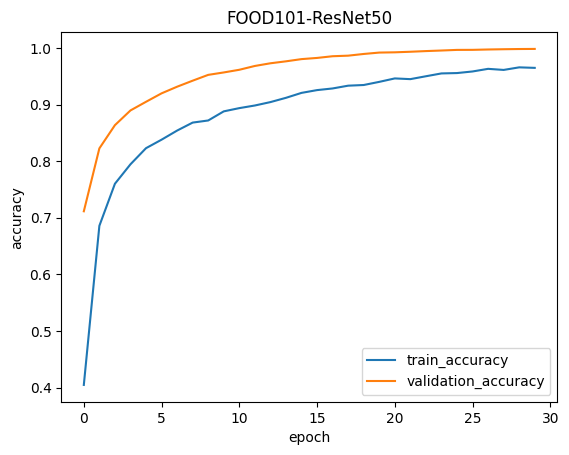

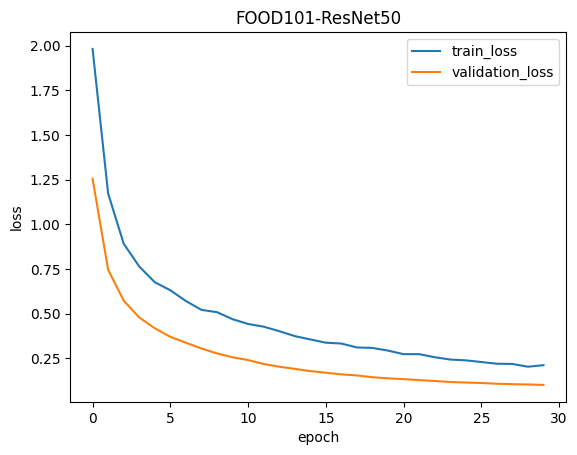

In [ ]:
plot_accuracy(history_11class,'FOOD101-ResNet50')
plot_loss(history_11class,'FOOD101-ResNet50')